# Natural Language Processing

### Learning Objectives:

- Define what types of data are considered "natural language" data
- Discuss the pros and cons of some pre-processing steps often used with natural language data (removing stopwords, for example)
- Extract features suitable for machine learning from text data
- Use a supervised classifier to classify texts after appropriate pre-processing

-----

So what is natural language processing? What kinds of data falls into the "natural language" bucket? What types of data are similar that you've already seen? What topics have we already discussed in the curriculum that lead up to this section?

- We can think of natural language as anything involving human communication - such as text documents, voice recordings
- Typically, when we talk about "natural language processing" we're talking about text data - although it could also include sound data
- Language data is actually quite similar to time series data - the sequence of language data is an important, defining characteristic
- We already talked about Naive Bayes, which is often used for text classification

## Processing Text Data

Using the 'Spooky Authors' dataset: https://www.kaggle.com/c/spooky-author-identification/overview

Goal: determine whether a chunk of text was written by Edgar Allen Poe, HP Lovecraft or Mary Shelley (multi-class classification problem)

In [1]:
# Wall of imports
import pandas as pd
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

First let's grab the dataset and look at a few aspects of this dataset (shape, some examples, etc). We'll be using just the train csv for this, for ease of use!

In [2]:
# Grab the train set from the competition 
df = pd.read_csv("spooky-author-identification/train.csv")

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
df.shape

(19579, 3)

In [5]:
# Exploring an example of one of the texts
df['text'][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [6]:
# Encoding our target from author initials to numbers
le = LabelEncoder()
df['target'] = le.fit_transform(df['author'])

In [7]:
# Checking that change
df.head()

,id,text,author,target
0,id26305,"This process, however, afforded me no means of...",EAP,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1


In [8]:
# Grabbing our inputs and target
X = df['text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
X_test

6148     The gigantic magnitude and the immediately ava...
4881     Shall I disturb this calm by mingling in the w...
16114    He had seen so many customs and witnessed so g...
738      We went up stairs into the chamber where the b...
13435    Over those horrors the evil moon now hung very...
                               ...                        
9245     "You then," I asked, "still remain in Greece?"...
6814     Of my frantic ascent of the slope and cliff, a...
2246     From your lips first have I heard the voice of...
11626    They attired me for the coffin three or four d...
3031     Yet we advanced slowly: sometimes I thought th...
Name: text, Length: 4895, dtype: object

In [10]:
# Grabbing a list of stopwords from NLTK, imported above
# We're also using the string library add punctuation to our list
stopwords_list = stopwords.words('english') + list(string.punctuation)

In [11]:
stopwords_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

What is the point of a list of stopwords? How/why will we use this list?

- "stopwords" have no inherent meaning and provide no use to a machine who doesn't care about grammar - we'll use this list to remove these words from our texts, so the algorithm focuses on words that actually might distinguish one author from another


### "Bag of Words" - Count Vectorizer

Useful link to the 'User Guide' part of the documentation on this: https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage

In [12]:
# Intstantiating our vectorizer
count_vectorizer = CountVectorizer()

# Training on the train set, then transforming the train set
X_count_train = count_vectorizer.fit_transform(X_train)
# Transforming the test set
X_count_test = count_vectorizer.transform(X_test)

In [13]:
# Instantiating a classifier to use on this text - Multinomial Naive Bayes
nb_classifier = MultinomialNB()

# Fitting the classifier
nb_classifier.fit(X_count_train, y_train)

# Getting our predictions for the train and test sets
train_preds = nb_classifier.predict(X_count_train)
test_preds = nb_classifier.predict(X_count_test)

0.8330949948927477


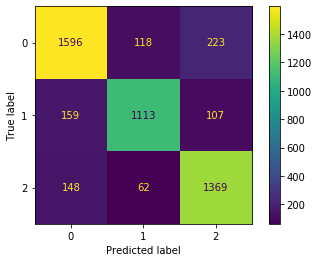

In [14]:
# Let's see how we did!
print(accuracy_score(y_test, test_preds))
plot_confusion_matrix(nb_classifier, X_count_test, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

Discuss! How did we do? What could we change?

- fairly high accuracy right off the bat, doesn't appear to favor one class over another too much
- did we even use our stopwords list?


We're about to try this on a few different vectorizers, so let's make that easier!

Here, I'm writing a function where we can provide an instantiated vectorizer, an instantiated classifer, and all of our train and test data, and the function will spit out the accuracy score and confusion matrix just like above:

In [15]:
def classify_vectorized_text(vectorizer, classifier, Xtrain, Xtest, ytrain, ytest):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs: 
    train_preds: predicted results for the train set
    test_preds: predicted results for the test set
    '''

    Xtrain_transformed = vectorizer.fit_transform(Xtrain)
    Xtest_transformed = vectorizer.transform(Xtest)

    classifier.fit(Xtrain_transformed, ytrain)

    train_preds = classifier.predict(Xtrain_transformed)
    test_preds = classifier.predict(Xtest_transformed)

    print(accuracy_score(ytest, test_preds))
    plot_confusion_matrix(classifier, Xtest_transformed, ytest,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

Let's add in something that was missing from our first Count Vectorizer:

Link to the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [31]:
# Intstantiating a count vectorizer that removes stop words
count_stop = CountVectorizer(stop_words = stopwords_list)

count_stop_train = count_stop.fit_transform(X_train)
count_stop_test = count_stop.transform(X_test)

Now let's create a new classifier and compare the results, using our previously-defined function!

0.8286006128702758


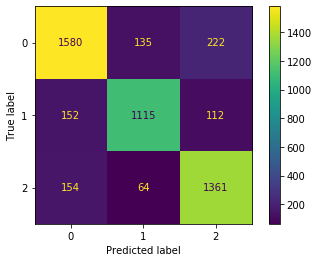

In [17]:
# Trying the same classifier, but now with stopwords removed
nb_stop = MultinomialNB()

stop_train_preds, stop_test_preds = classify_vectorized_text(
    count_stop, nb_stop, X_train, X_test, y_train, y_test)

Compare/discuss: 

- slightly worse accuracy than before! but not drastically so - actually correctly classifies a few more "Class 1" than before, but got worse on "Class 0" and "Class 2"
- what does it mean for stopwords to help our classifier? is our machine learning algorithm learning the right things, or just found that maybe one author uses more pronouns or something than other authors? hard to tell!


### TF-IDF: Term-Frequency - Inverse Document-Frequency

Woah, that's a term and a half. What even is it?

From [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html):

> "The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus."

Basically, it's a statistic that hopefully reflects how important a word is in the document. By looking at the overall frequency you find how common a word is across the whole corpus, compared to the document frequency that shows how common a word is within the document in question. If a word appears often in our document, but relatively rarely in the corpus, it probably captures an important word in that specific document!

In this example, the training corpus is every sentence in the `text` column in our train set, and the document is the individual sentence that we're trying to classify (per row).

Reference: http://www.tfidf.com/

We'll be using Sklearn's [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), which is 'equivalent to CountVectorizer followed by TfidfTransformer'

In [18]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [19]:
# Here, number of rows is the length of our train set
tfidf_train.shape

(14684, 13556)

In [20]:
# Here, number of rows is the length of our test set
tfidf_test.shape

(4895, 13556)

We can actually explore what our vectorizer is grabbing from the test data.

In [21]:
# Let's look at the 16th doc in our test set
X_test.iloc[15]

'Each animal if you will take the pains to observe, is following, very quietly, in the wake of its master.'

In [22]:
# Creating a df of tf-idf values, where each column is a word in the vocabulary
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [23]:
# Grabbing that row once it's been vectorized
test_doc = tfidf_test_df.iloc[15]

print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0

wake         0.427933
pains        0.380251
quietly      0.374526
observe      0.351341
master       0.349693
following    0.328913
animal       0.322027
take         0.272767
Name: 15, dtype: float64


This tells you that for the 16th document in our test set, the word 'wake' has the highest TF-IDF value.

What does this tell you about the word "wake" in the this document of our test set?

- 'Wake' is infrequently used across our corpus (not used in many sentences), but occurs in this document/sentence and is likely providing more information than other words in this document/sentence since it doesn't appear much elsewhere


In [32]:
# Let's compare to our earlier count vectorizer for this document
count_test_df = pd.DataFrame(count_stop_test.toarray(), columns=count_stop.get_feature_names())

In [33]:
count_test_doc = count_test_df.iloc[15]

print(count_test_doc.loc[count_test_doc > 0].sort_values(ascending=False)) # Showing values > 0

wake         1
take         1
quietly      1
pains        1
observe      1
master       1
following    1
animal       1
Name: 15, dtype: int64


Easy to discuss here why using a TF-IDF Vectorizer might have some added benefits compared to a straight Count Vectorizer.

0.814708886618999


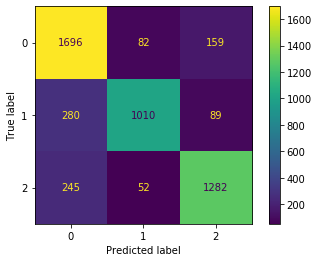

In [24]:
# Now, back to classifying: 
# Using our function to compare the results...
nb_tfidf = MultinomialNB()

tfidf_train_preds, tfidf_test_preds = classify_vectorized_text(tfidf, nb_tfidf, X_train, X_test, y_train, y_test)

Compare/discuss:

- getting even worse! but not drastically so. now, we're better at classifying "Class 0" but worse at classifying "Class 1" and "Class 2"


0.7105209397344229


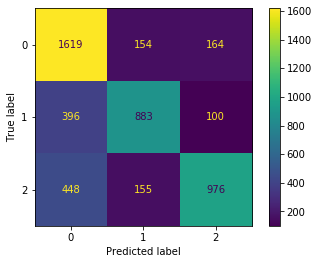

In [25]:
# We can also use our function to try different classifiers

rfc = RandomForestClassifier(n_estimators=100)

rfc_train_preds, rfc_test_preds = classify_vectorized_text(tfidf, rfc, X_train, X_test, y_train, y_test)

Compare/discuss: 

- woah that got way worse, so multinomial naive bayes is probably a better model to capture the relationship between and within these texts than this untuned random forest ensemble


## Additional Resources

- Sklearn's [Working with Text Data Tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

What else can we do with natural language data beyond text classification? 

- [This blog post](https://blog.aureusanalytics.com/blog/5-natural-language-processing-techniques-for-extracting-information) by Aureus Analytics provides an overview of other machine learning techniques used to extract meaning from text: Named Entity Recognition, Sentiment Analysis, Text Summarization, Aspect Mining and Topic Modeling

### Neural Network Vectorizer Resources:

Want to go beyond Count Vectorizers or TF-IDF to embed words for machine learning? Check out Word2Vec - a way of vectorizing text that tries to capture the relationships between words. See the image below, from [this paper](https://arxiv.org/pdf/1310.4546.pdf) from Google developers, that introduced a Skip-gram neural network model that's been utilized by Word2Vec (which is a tool you can use to implement this model). You'll note that the distance between each country and it's capital city is about the same - that distance actually has meaning, and thus you can imagine that the difference between `cat` and `kitten` would be the same as the difference between `dog` and `puppy`. Et cetera!

![screenshot from a paper on the Skip-gram model from devleopers at Google, https://arxiv.org/pdf/1310.4546.pdf](Fig2-DsitributedRepresentationsOfWordsAndPhrasesAndTheirCompositionality.png)

- [Pathmind's A.I. Wiki - A Beginner's Guide to Word2Vec](https://wiki.pathmind.com/word2vec)
- [Chris McCormick's Word2Vec Tutorial](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)